### INTRODUCTION: 
The dataset is from the recent [kaggle competition](https://www.kaggle.com/c/tweet-sentiment-extraction/overview) where the objective is to classify the given tweet as positive, negative or neutral from labelled dataset. The secondary objective is to also return the text and its neighbourhood in the text to depict the sentiment.
We are focussing of the primary objective solely in this notebook and examining the effectiveness on using LSTM for text classification into the sentiments of the texts. 
We also attempt hyperparameter tuning to acheive satisfactory results on vectorized text using Word2vec method.


### SOLUTION

#### Imports

In [0]:
#Data Processing
import pandas as pd

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.python.keras import utils
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools



### OPTION 1: FROM DRIVE
####Drive Mount

In [0]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

### Loading the train dataset and the test dataset

In [0]:
train = pd.read_csv('/content/drive/My Drive/Twitter_Sentiment_Analysis/train.csv')
test = pd.read_csv('/content/drive/My Drive/Twitter_Sentiment_Analysis/test.csv')

### OPTION 2: From local directory

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Examining the dataset

In [0]:
train.head()

In [0]:
test.head()

There exists non uniform length text in train and test dataset and there exists 3 categories of sentiments positive, negative and neutral

In [0]:
#Getting stopwords from nltk library
nltk.download('stopwords')


#### VARIABLE INITIALISATIONS


In [0]:
# Data Processing
DATASET_COLUMNS = ["sentiment", "textID", "text", "selected_text"]
TRAIN_SIZE = 0.8

# TEXT CLEANING REGEX INFORMATION
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC parameters
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# Keras Layers
SEQUENCE_LENGTH = 300
BATCH_SIZE = 1024

# Sentiment
POSITIVE = "positive"
NEGATIVE = "negative"
NEUTRAL = "neutral"
SENTIMENT_THRESHOLDS = (0.4, 0.7)



#### Class Balance visualisation in target attribute

In [0]:
sentiment_cnt = Counter(train.sentiment)
plt.figure(figsize=(16,8))
plt.bar(sentiment_cnt.keys(), sentiment_cnt.values())
plt.title("Dataset labels distribuition")


In [0]:
#Intializing stopwords and getting snowball stemmer before vectorization
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")


#### Function to preprocess and clean text attribute of train data

In [0]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)


#### Function call to preprocess test and train dataset

In [0]:
train.text = train.text.apply(lambda x: preprocess(x))
test.text = test.text.apply(lambda x: preprocess(x))

In [0]:
df_train, df_test = train_test_split(train, test_size=1-TRAIN_SIZE, random_state=42, stratify=train.sentiment)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))


In [0]:
documents = [_text.split() for _text in df_train.text] 


In [0]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [0]:
w2v_model.build_vocab(documents)


In [0]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)


In [0]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)


In [0]:
w2v_model.most_similar("love")


In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)


In [0]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)


In [0]:
labels = df_train.sentiment.unique().tolist()
labels

In [0]:
encoder = LabelEncoder()
encoder.fit(['negative','neutral','positive'])

y_train = encoder.transform(df_train.sentiment.tolist())
y_test = encoder.transform(df_test.sentiment.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)


In [0]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)


In [0]:
y_train[:10]


In [0]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)


In [0]:
embedding_matrix

In [0]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)


In [0]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE
        
        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE


In [0]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)


In [0]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  


In [0]:
def model_on_data(more_layer, output,activation, loss,  epoches, optimizer, initializer,lstmactivation):
      model = Sequential()
      model.add(embedding_layer)
      model.add(Dropout(0.5))
      
      if more_layer==False:

        model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,recurrent_initializer=initializer, activation=lstmactivation))
      else: 
        # model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,recurrent_initializer=initializer, activation=lstmactivation,return_sequences=True))

        model.add(LSTM(100, return_sequences=True,recurrent_initializer=initializer, activation=lstmactivation))  # returns a sequence of vectors of dimension 32
        # model.add(LSTM(100))

      model.add(Dense(output, activation=activation))

      print(model.summary())
      model.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=['accuracy'])
      callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
                    EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]
      history = model.fit(x_train, y_train,
                          batch_size=BATCH_SIZE,
                          epochs=epoches,
                          validation_split=0.1,
                          verbose=1,
                          callbacks=callbacks)
      print(history)
      score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
      print()
      print("ACCURACY:",score[1])
      print("LOSS:",score[0])
      acc = history.history['accuracy']
      val_acc = history.history['val_accuracy']
      loss = history.history['loss']
      val_loss = history.history['val_loss']
      
      epochs = range(len(acc))
      
      plt.plot(epochs, acc, 'b', label='Training acc')
      plt.plot(epochs, val_acc, 'r', label='Validation acc')
      plt.title('Training and validation accuracy')
      plt.legend()
      
      plt.figure()
      
      plt.plot(epochs, loss, 'b', label='Training loss')
      plt.plot(epochs, val_loss, 'r', label='Validation loss')
      plt.title('Training and validation loss')
      plt.legend()
      
      plt.show()

      y_pred_1d = []
      y_test_1d = list(df_test.sentiment)
      scores = model.predict(x_test, verbose=1, batch_size=8000)
      y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

      cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
      plt.figure(figsize=(12,12))
      plot_confusion_matrix(cnf_matrix, classes=df_train.sentiment.unique(), title="Confusion matrix")
      plt.show()

      print(classification_report(y_test_1d, y_pred_1d))
      print(accuracy_score(y_test_1d, y_pred_1d))



In [0]:
# more_layer=[True,False]
# output=[1,3]
# activation=[ 'softmax', 'sigmoid']
# loss= ['binary_crossentropy', 'categorical_crossentropy']
# epoches=[20, 50, 100]
# optimizer=['adam', 'sgd+momentum']
# initializer[he, xavier]


In [0]:
model_on_data(more_layer=False, output=1,activation='sigmoid', loss='binary_crossentropy',  epoches=10, optimizer='adam', initializer='he_normal',lstmactivation='tanh' )


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          6403500   
_________________________________________________________________
dropout_6 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 6,564,001
Trainable params: 160,501
Non-trainable params: 6,403,500
_________________________________________________________________
None
Epoch 1/10
20/20 [==============================] - 22s 1s/step - loss: 0.1019 - accuracy: 0.3997 - val_loss: -0.3384 - val_accuracy: 0.4020 - lr: 0.0010
Epoch 2/10
20/20 [==============================] - 23s 1s/step - loss: -0.53

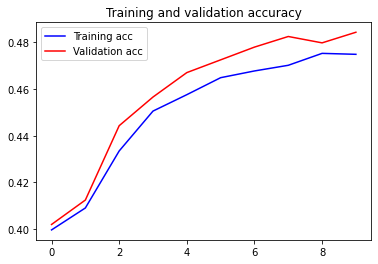

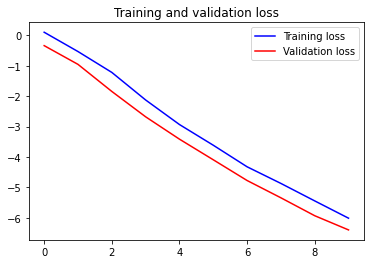

1/1 [==============================] - 0s 989us/step


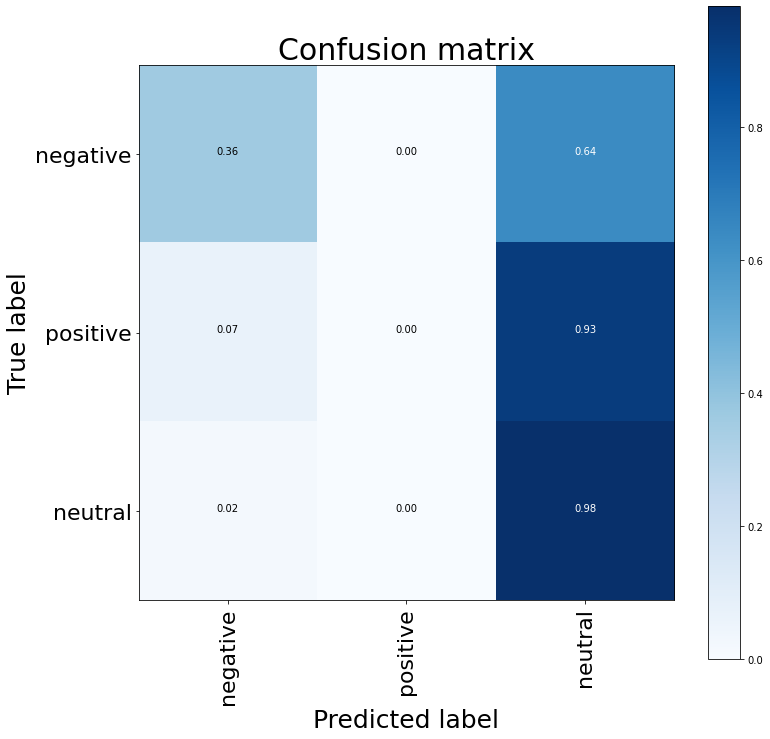

              precision    recall  f1-score   support

    negative       0.76      0.36      0.49      1557
     neutral       0.00      0.00      0.00      2224
    positive       0.35      0.98      0.52      1717

    accuracy                           0.41      5498
   macro avg       0.37      0.45      0.34      5498
weighted avg       0.33      0.41      0.30      5498

0.40942160785740267


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
SENTIMENT_THRESHOLDS = (0.2, 0.5)
model_on_data(more_layer=False, output=1,activation='sigmoid', loss='binary_crossentropy',  epoches=10, optimizer='adam', initializer='he_normal',lstmactivation='tanh' )


## HYPERPARAMETER TUNING

### Changing Activation Function

#### LSTM activation relu

In [0]:
SENTIMENT_THRESHOLDS = (0.4, 0.7)

model_on_data(more_layer=False, output=1,activation='sigmoid', loss='binary_crossentropy',  epoches=10, optimizer='adam', initializer='he_normal',lstmactivation='relu' )


#### LSTM activation selu

In [0]:
model_on_data(more_layer=False, output=1,activation='sigmoid', loss='binary_crossentropy',  epoches=10, optimizer='adam', initializer='he_normal',lstmactivation='selu' )


bold text### Cost Function

#### Loss : Hinge loss

In [0]:
model_on_data(more_layer=False, output=1,activation='sigmoid', loss='hinge',  epoches=10, optimizer='adam', initializer='he_normal',lstmactivation='tanh' )


#### Loss: Huber Loss

In [0]:
model_on_data(more_layer=False, output=1,activation='sigmoid', loss='huber_loss',  epoches=10, optimizer='adam', initializer='he_normal',lstmactivation='tanh' )


### EPOCHES

#### Epoches=20

In [0]:
model_on_data(more_layer=False, output=1,activation='sigmoid', loss='huber_loss',  epoches=20, optimizer='adam', initializer='he_normal',lstmactivation='tanh' )


#### Epoches= 8

In [0]:
model_on_data(more_layer=False, output=1,activation='sigmoid', loss='huber_loss',  epoches=8, optimizer='adam', initializer='he_normal',lstmactivation='tanh' )


### Gradient Optimization Function

#### SGD

In [0]:
from keras import optimizers


model_on_data(more_layer=False, output=1,activation='sigmoid', loss='huber_loss',  epoches=8, optimizer='sgd', initializer='he_normal',lstmactivation='tanh' )


#### Adagrad

In [0]:
model_on_data(more_layer=False, output=1,activation='sigmoid', loss='huber_loss',  epoches=8, optimizer='adagrad', initializer='he_normal',lstmactivation='tanh' )


### Network Architecture

#### With more layers

In [0]:
model_on_data(more_layer=True, output=1,activation='sigmoid', loss='huber_loss',  epoches=8, optimizer='adam', initializer='he_normal',lstmactivation='tanh' )


In [0]:
model_on_data(more_layer=True, output=1,activation='sigmoid', loss='huber_loss',  epoches=8, optimizer='adam', initializer='he_normal',lstmactivation='tanh' )


### Weight Initialization

#### lecun_uniform

In [0]:
model_on_data(more_layer=False, output=1,activation='sigmoid', loss='huber_loss',  epoches=8, optimizer='adam', initializer='lecun_uniform',lstmactivation='tanh' )


#### RandomUniform

In [0]:
model_on_data(more_layer=False, output=1,activation='sigmoid', loss='huber_loss',  epoches=8, optimizer='adam', initializer='random_uniform',lstmactivation='tanh' )


### CONCLUSION
Best accuracy was obtaines when more_layer=False, output=1,activation='sigmoid', loss='huber_loss',  epoches=20, optimizer='adam', initializer='he_normal',lstmactivation='tanh' => 50.5%

However best choice is owing to the fact that precisions of all classes was decent  when more_layer=False, output=1,activation='sigmoid', loss='binary_crossentropy',  epoches=10, optimizer='adam', initializer='he_normal',lstmactivation='tanh' 

Further improvements in score can be implemented using pretrained state of art models like BERT, Distilbert, Albert etc or using GloVe language models and better text preprocessing, cross validation, data collection

### CONTRIBUTION
Self: External aid = 50:50
The functions for hyperparameter tuning are done by self and the code has been adapted from various refernces with modifications for use case of the problem statement

### REFERENCES



1.   https://keras.io
2.   https://www.kaggle.com/c/tweet-sentiment-extraction/overview
3.   https://www.kaggle.com/harupy/op-scoring-kernels-tweet-sentiment-extraction
4.   https://keras.io/getting-started/sequential-model-guide/
5.   https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046




### License

MIT License

Copyright (c) 2020 Suprita Ganesh

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
